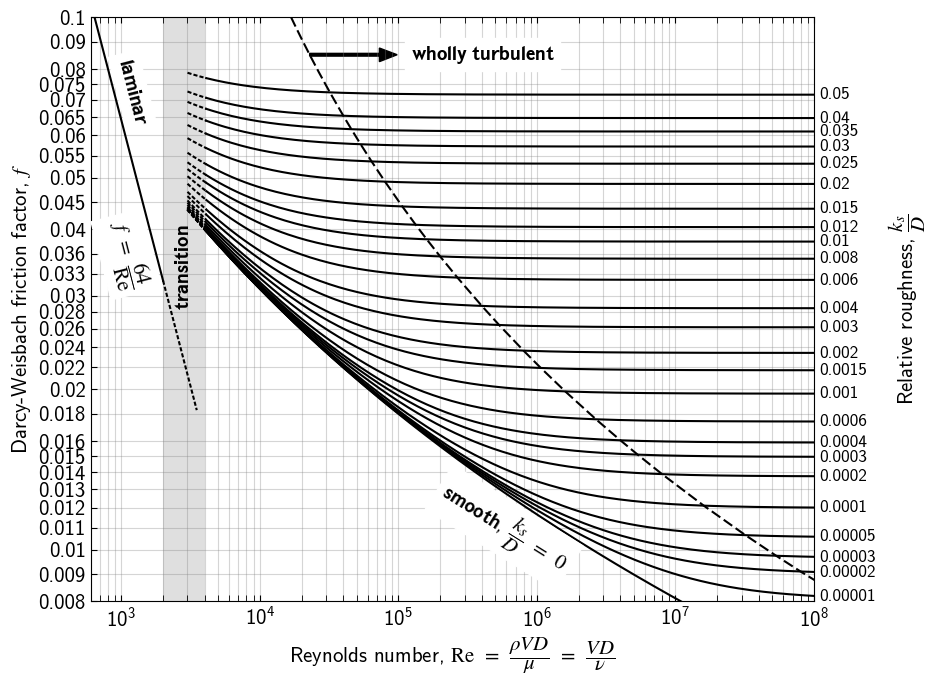

In [1]:
########################################################
########################################################
# Lecture 7 - Flow Resistance (Moody Diagram)
# Created for CEE 474 / CEWA 574, Spring 2021
# By Jacob A. Morgan, Ph.D.
#    University of Washington
#
# Parts of this script originally from Daniel G. Hyams
########################################################
########################################################

import numpy as np
import scipy.optimize
import functools
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

mpl.rcParams['figure.figsize'] = (10.0+1./3.,8.0)
mpl.rcParams['font.size'] = 15.0
mpl.rcParams['figure.subplot.left'] = 0.15
mpl.rcParams['figure.subplot.right'] = 0.85
mpl.rcParams['figure.subplot.bottom'] = 0.15
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color',['black'])
ccycle = mpl.rcParams['axes.prop_cycle']
plt.rcParams['font.family']=['sans-serif']#['STIXGeneral','Times New Roman','DejaVu Serif']
mpl.rcParams['mathtext.fontset'] = 'stix'
rc('font',**{'sans-serif':['Helvetica','Arial','cmss10']})

def colebrook(f,ks_D,Re):
    # meant to be used as part of a Newton iteration, so the equation has been
    # rearranged such that it is equal to zero.
    sf = np.sqrt(f)
    return -2*np.log10(ks_D/3.7 + 2.51/Re/sf) - 1/sf

fff = plt.figure()

# list of relative roughnesses to compute a curve for.
rrlist = [0.0,0.00001,0.00002,0.00003,0.00005,0.0001,0.0002,0.0003,0.0004,0.0006,0.001,0.0015,0.002,
          0.003,0.004,0.006,0.008,0.01,0.012,0.015,0.02,0.025,0.03,0.035,0.04,0.05]

# range of Reynolds numbers to use for computing the turbulent friction factors.
# Will be equally spaced logarithmically over the range.
Remin_t = 3e3
Remax_t = 100e6

# set the limits of the chart
Remin = 6e2
Remax = Remax_t
fmin  = 0.008
fmax = 0.1

Rerange = np.linspace(np.log10(Remin_t),np.log10(Remax_t),200)
Rerange = 10**Rerange

# do the computation first.
f0 = 0.03
curve = {}
for ks_D in rrlist:
    ff = np.zeros(Rerange.shape)
    for idx,Re in enumerate(Rerange):
        func = functools.partial(colebrook,ks_D=ks_D,Re=Re)
        f = scipy.optimize.newton(func,f0)
        ff[idx] = f
        f0 = f # use the initial guess from previous solution
    curve[ks_D] = ff

# generate the data for the curve that shows the demarcation between transitional flow
# and fully rough flow.    
ReT = []
fT = []
f0 = curve[rrlist[1]][-1]
for ks_D in rrlist[1:] + [0.06,0.07,0.08,0.09,0.1]:
    ReT.append(1600.0/ks_D)
    func = functools.partial(colebrook,ks_D=ks_D,Re=ReT[-1])
    fT.append(scipy.optimize.newton(func,f0))
    f0 = fT[-1]
        
# also compute the laminar friction factor
Rerange_l1 = np.linspace(np.log10(1e2),np.log10(2e3),5)
Rerange_l1 = 10**Rerange_l1
Rerange_l2 = np.linspace(np.log10(2e3),np.log10(3.5e3),5)
Rerange_l2 = 10**Rerange_l2
flaminar1 = 64/Rerange_l1
flaminar2 = 64/Rerange_l2

# now, do some plotting.

# plot the laminar curve   
plt.loglog(Rerange_l1,flaminar1,color='black',lw=1.5)
plt.text(900,64/775,r"$\bf{\mathsf{laminar}}$",va='bottom',ha='left',backgroundcolor='w',
         rotation=-75.5,rotation_mode='anchor',fontfamily='sans-serif',fontweight='bold')
plt.text(1300,64/1510,r"$f\,\,\,=\,\,\,\dfrac{64}{\mathrm{Re}}$",va='top',ha='left',
         backgroundcolor='w',rotation=-75.5,
        rotation_mode='anchor')
plt.loglog(Rerange_l2,flaminar2,color='black',linestyle='dashed',dashes=[2,1],lw=1.5)

# plot the curves in the transitional/turbulent zone for each roughness
for i,ks_D in enumerate(rrlist):
   cutoff = 7
   plt.loglog( Rerange[cutoff-1:],curve[ks_D][cutoff-1:],
              color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][i%len(ccycle)],
              linewidth=1.5)
   plt.loglog( Rerange[:cutoff],curve[ks_D][:cutoff],
              color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][i%len(ccycle)],
              linewidth=1.5,dashes=[2,1])
   yfinal = curve[ks_D][-1]
   xfinal = Rerange[-1] + Rerange[-1]/10.0 # fudge a little to the right
   if yfinal > 0.008: 
        if ks_D >= 0.0001:
            plt.text(xfinal,yfinal,"%g"%ks_D,size='small',va='center')
        else:
            plt.text(xfinal,yfinal,"%.5f"%ks_D,size='small',va='center')
   
# plot the division between transitional and fully rough flow.  
plt.loglog(ReT,fT,color='black',linestyle='dashed',dashes=[5,2],linewidth=1.5)
plt.text(ReT[-4]+0.5e5+5e4,fT[-4],r"$\bf{\mathsf{wholly\,\,turbulent}}$",va='center',
         ha='left',backgroundcolor='w',fontfamily='sans-serif')
plt.arrow(ReT[-4],fT[-4],0.5e5,0,head_length=2.5e4,head_width=0.005)

ax = plt.gca()   
plt.xlim(Remin,Remax)
plt.ylim(fmin,fmax)

plt.ylabel(r"Darcy-Weisbach friction factor, $f$",fontfamily='sans-serif')
plt.xlabel(r"Reynolds number, " + 
           r"$\mathrm{Re}\,\,\,=\,\,\,\dfrac{\rho V D}{\mu}\,\,\,=" + 
           r"\,\,\,\dfrac{V D}{\nu}$",fontfamily='sans-serif')
plt.text(1.1,0.5,r"Relative roughness, $\dfrac{k_s}{D}$",
         transform=plt.gca().transAxes,rotation='vertical',va='center',
        fontfamily='sans-serif')
plt.text(0.58e6,.011,r"$\bf{\mathsf{smooth}}$, $\dfrac{k_s}{D}\,\,\,=\,\,\,0$",va='center',
         ha='center',rotation=-32,backgroundcolor='white',fontfamily='sans-serif')

plt.yticks(np.append(np.append(np.append(np.append(np.arange(0.008,0.016,0.001),
                                                   np.arange(0.016,0.03,0.002)),
                                         np.arange(0.03,0.038,0.003)),
                               np.arange(0.04,0.085,0.005)),
                     np.arange(0.09,0.1,0.01)))
#ax.yaxis.grid(True, which='minor')
plt.grid(True,which='both',linestyle='solid',color='gray',alpha=0.33)
yformatter = mpl.ticker.FormatStrFormatter("%g")
ax.yaxis.set_major_formatter(yformatter)
ax.yaxis.set_minor_formatter(yformatter)
ax.tick_params(which='both',top=True,direction="in",length=4)

plt.fill([2000,2000,4000,4000],[0.008,0.1,0.1,0.008],'gray',alpha=0.25)
plt.text(np.sqrt(np.multiply(2000,4000)),0.034,r"$\bf{\mathsf{transition}}$",ha='center',va='center',
        rotation=90)

plt.show()
